## Diabetes Progression Prediction
Predicts the person's progression in the condition with respect to various attributes.

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mstats
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from joblib import dump

In [61]:
# load insurance data
diabetes_df = pd.read_csv('diabetes.csv')
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AGE          442 non-null    int64  
 1   SEX          442 non-null    int64  
 2   BMI          442 non-null    float64
 3   BP           442 non-null    float64
 4   S1           442 non-null    int64  
 5   S2           442 non-null    float64
 6   S3           442 non-null    float64
 7   S4           442 non-null    float64
 8   S5           442 non-null    float64
 9   S6           442 non-null    int64  
 10  PROGRESSION  442 non-null    int64  
dtypes: float64(6), int64(5)
memory usage: 38.1 KB


## Diabetes EDA

In [62]:
diabetes_df.head()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,PROGRESSION
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135


In [5]:
# get the summary statistics for the numerical columns
diabetes_df.describe()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,PROGRESSION
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,48.518100,1.468326,26.375792,94.647014,189.140271,115.439140,49.788462,4.070249,4.641411,91.260181,152.133484
std,13.109028,0.499561,4.418122,13.831283,34.608052,30.413081,12.934202,1.290450,0.522391,11.496335,77.093005
min,19.000000,1.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.258100,58.000000,25.000000
25%,38.250000,1.000000,23.200000,84.000000,164.250000,96.050000,40.250000,3.000000,4.276700,83.250000,87.000000
50%,50.000000,1.000000,25.700000,93.000000,186.000000,113.000000,48.000000,4.000000,4.620050,91.000000,140.500000
75%,59.000000,2.000000,29.275000,105.000000,209.750000,134.500000,57.750000,5.000000,4.997200,98.000000,211.500000
max,79.000000,2.000000,42.200000,133.000000,301.000000,242.400000,99.000000,9.090000,6.107000,124.000000,346.000000


In [63]:
# calculate the percentage of missing values per column
missing_data_rows = []
total_rows = len(diabetes_df)

for num in diabetes_df.columns:
    missing_values_count = diabetes_df[num].isnull().sum()
    percentage_missing_per_column = round((missing_values_count / total_rows) * 100)
    missing_data_rows.append({'Feature': num,'Missing Values Count': missing_values_count,'Percentage Missing': f"{percentage_missing_per_column}%"})

# convert the list of dictionaries into a dataFrame
missing_output_df = pd.DataFrame(missing_data_rows)
missing_output_df

,Feature,Missing Values Count,Percentage Missing
0,AGE,0,0%
1,SEX,0,0%
2,BMI,0,0%
3,BP,0,0%
4,S1,0,0%
5,S2,0,0%
6,S3,0,0%
7,S4,0,0%
8,S5,0,0%
9,S6,0,0%


Since there are no missing values in the datasets, there is no need for imputation.

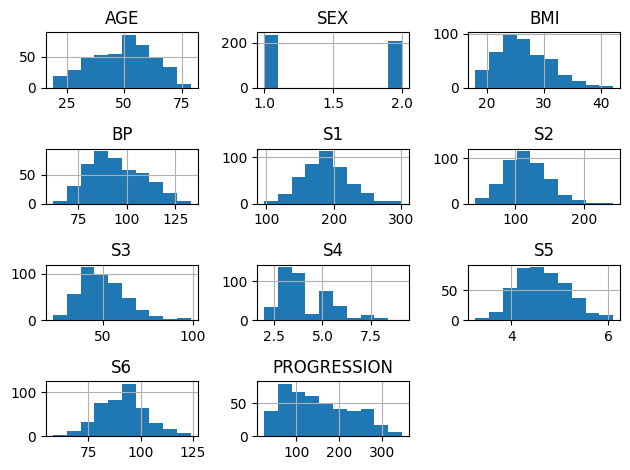

In [64]:
diabetes_df.hist()
plt.tight_layout()

"Glucose," "BloodPressure," and "BMI" follow Gaussian distributions, while the remaining variables exhibit non-Gaussian distributions.

<Axes: >

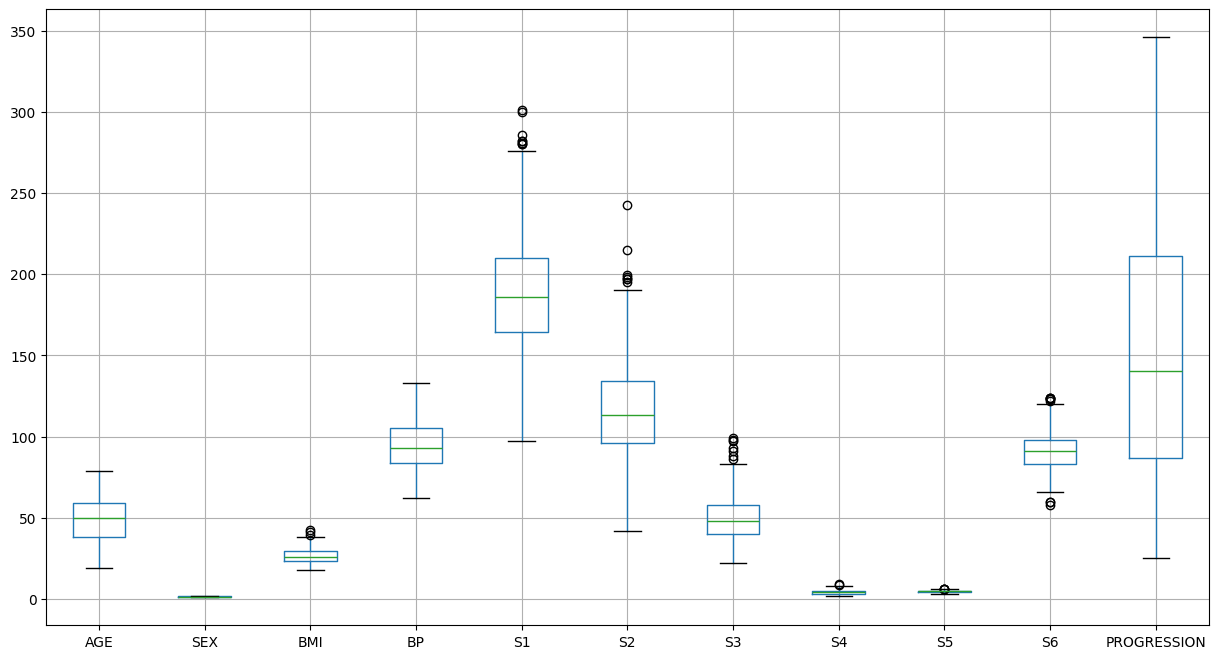

In [65]:
# plot the distribution of numerical features along with outliers
diabetes_df.boxplot(figsize=(15, 8))

7 out of 10 variables display outliers, which will be addressed using the Winsorization technique in the following section.

## Feature engineering

In [66]:
# position the charges column in the first column index
first_column = diabetes_df['PROGRESSION']

# drop this column from its current position
diabetes_df.drop(columns=['PROGRESSION'], inplace=True)

# Insert the column at the desired position (index 0)
diabetes_df.insert(0, 'PROGRESSION', first_column)

# Display the modified DataFrame
diabetes_df.head()

,PROGRESSION,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6
0,151,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87
1,75,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69
2,141,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85
3,206,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89
4,135,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80


In [67]:
# Define independent features (X) and dependent feature (y)
X = diabetes_df.drop(columns=['PROGRESSION'])  # Independent features
y = diabetes_df['PROGRESSION']  # Dependent feature

<Axes: >

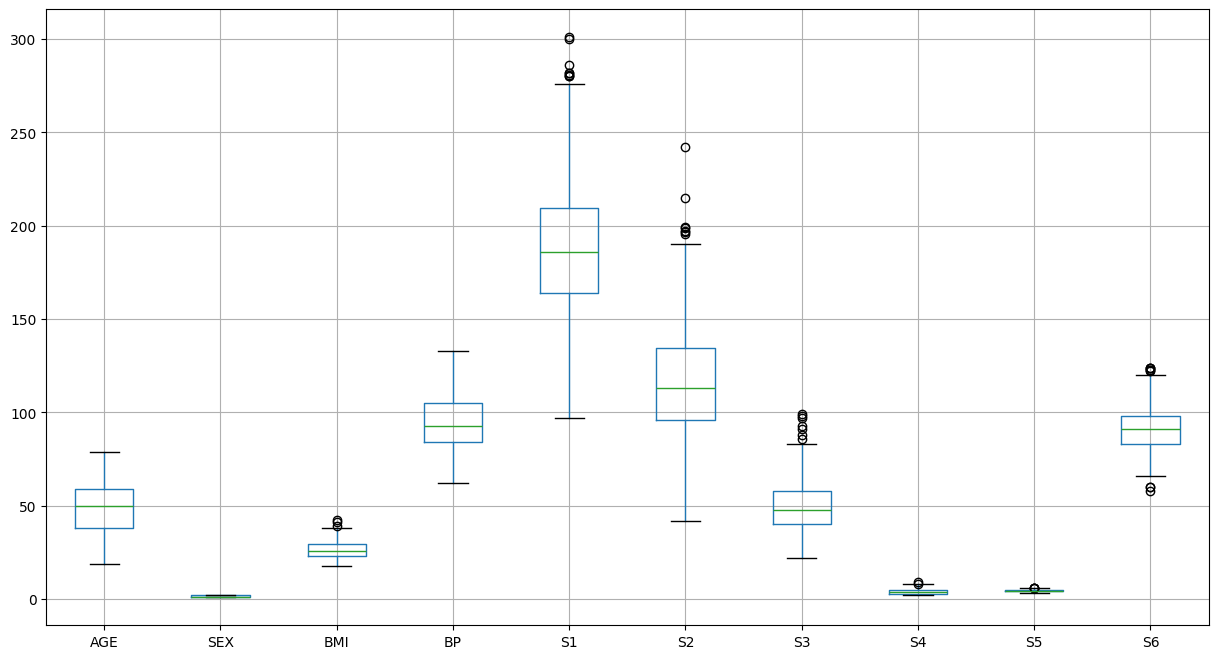

In [68]:
# plot the distribution of features
X.boxplot(figsize=(15, 8))

<Axes: >

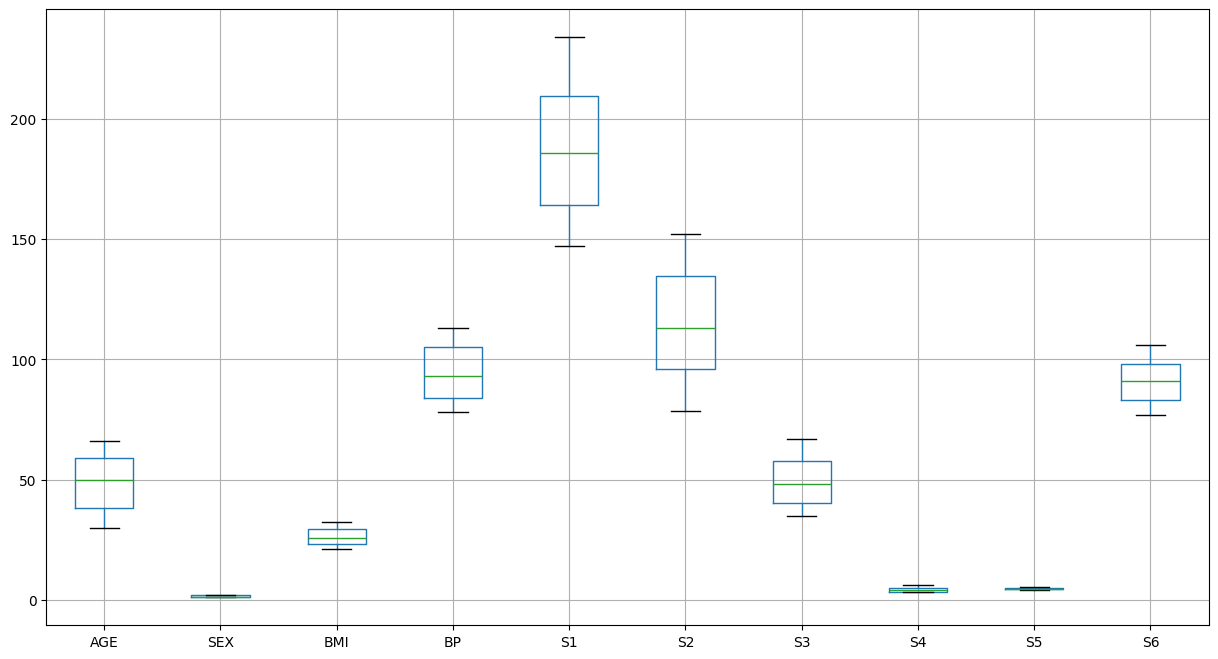

In [69]:
# Apply winsorization to each column and plot the effect of it on the outliers
for column in X:
    X[column] = mstats.winsorize(X[column], limits=(0.10, 0.10))
X.boxplot(figsize=(15, 8))

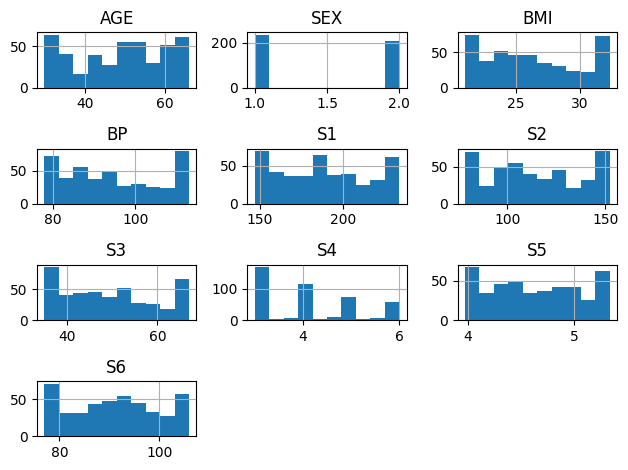

In [70]:
# plot the distribution of the X features after winsorization
X.hist()
plt.tight_layout()

After implementing Winsorization, the distributions of the features have been altered, making MinMaxScaler() more appropriate since no feature follows a Gaussian distribution suitable for StandardScaler(). Therefore, I forgo StandardScaler() and exclusively apply MinMaxScaler() to all features.

In [71]:
# use MinMaxScaler to normalise the X features
scaler = MinMaxScaler()

# fit the scaler to the data and transform the data
X_scaled = scaler.fit_transform(X)

# convert the scaled data back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# display the scaled DataFrame
X_scaled_df.head()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6
0,0.805556,1.0,0.982301,0.657143,0.114943,0.200542,0.09375,0.333333,0.650600,0.344828
1,0.500000,0.0,0.053097,0.257143,0.413793,0.336043,1.00000,0.000000,0.000000,0.000000
2,1.000000,1.0,0.840708,0.428571,0.103448,0.205962,0.18750,0.333333,0.513824,0.275862
3,0.000000,0.0,0.380531,0.171429,0.586207,0.718157,0.15625,0.666667,0.672908,0.413793
4,0.555556,0.0,0.176991,0.657143,0.517241,0.636856,0.53125,0.333333,0.234201,0.103448


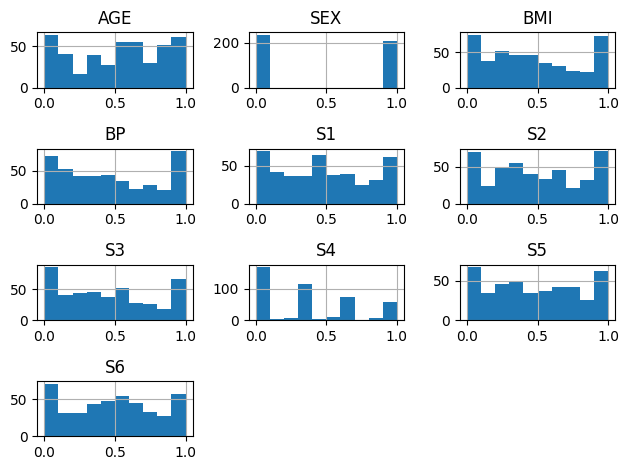

In [72]:
# plot the distributions of the X features after scaling
X_scaled_df.hist()
plt.tight_layout()

In [16]:
# concatenate the scaled features with the target variable
scaled_data_with_target = pd.concat([y,X_scaled_df], axis=1)

# display the scaled DataFrame
scaled_data_with_target.head()

,PROGRESSION,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6
0,151,0.805556,1.0,0.982301,0.657143,0.114943,0.200542,0.09375,0.333333,0.650600,0.344828
1,75,0.500000,0.0,0.053097,0.257143,0.413793,0.336043,1.00000,0.000000,0.000000,0.000000
2,141,1.000000,1.0,0.840708,0.428571,0.103448,0.205962,0.18750,0.333333,0.513824,0.275862
3,206,0.000000,0.0,0.380531,0.171429,0.586207,0.718157,0.15625,0.666667,0.672908,0.413793
4,135,0.555556,0.0,0.176991,0.657143,0.517241,0.636856,0.53125,0.333333,0.234201,0.103448


### Correlation between independant variables and the dependant variable "Outcome"

In [73]:
corr_matrix = scaled_data_with_target.corr()
corr_matrix

,PROGRESSION,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6
PROGRESSION,1.000000,0.188476,0.043062,0.569686,0.430701,0.218777,0.179458,-0.403520,0.427850,0.585358,0.370286
AGE,0.188476,1.000000,0.173123,0.170585,0.356060,0.267336,0.222274,-0.089634,0.205799,0.259494,0.292601
SEX,0.043062,0.173123,1.000000,0.080539,0.260490,0.033021,0.136264,-0.394113,0.338488,0.173323,0.204901
BMI,0.569686,0.170585,0.080539,1.000000,0.378990,0.264958,0.274360,-0.371640,0.406600,0.485017,0.381178
BP,0.430701,0.356060,0.260490,0.378990,1.000000,0.265546,0.188003,-0.196663,0.264510,0.400824,0.381514
S1,0.218777,0.267336,0.033021,0.264958,0.265546,1.000000,0.873477,0.017894,0.516545,0.521829,0.323693
S2,0.179458,0.222274,0.136264,0.274360,0.188003,0.873477,1.000000,-0.195987,0.622530,0.351969,0.283386
S3,-0.403520,-0.089634,-0.394113,-0.371640,-0.196663,0.017894,-0.195987,1.000000,-0.749600,-0.437108,-0.286297
S4,0.427850,0.205799,0.338488,0.406600,0.264510,0.516545,0.622530,-0.749600,1.000000,0.627461,0.405308
S5,0.585358,0.259494,0.173323,0.485017,0.400824,0.521829,0.351969,-0.437108,0.627461,1.000000,0.448704


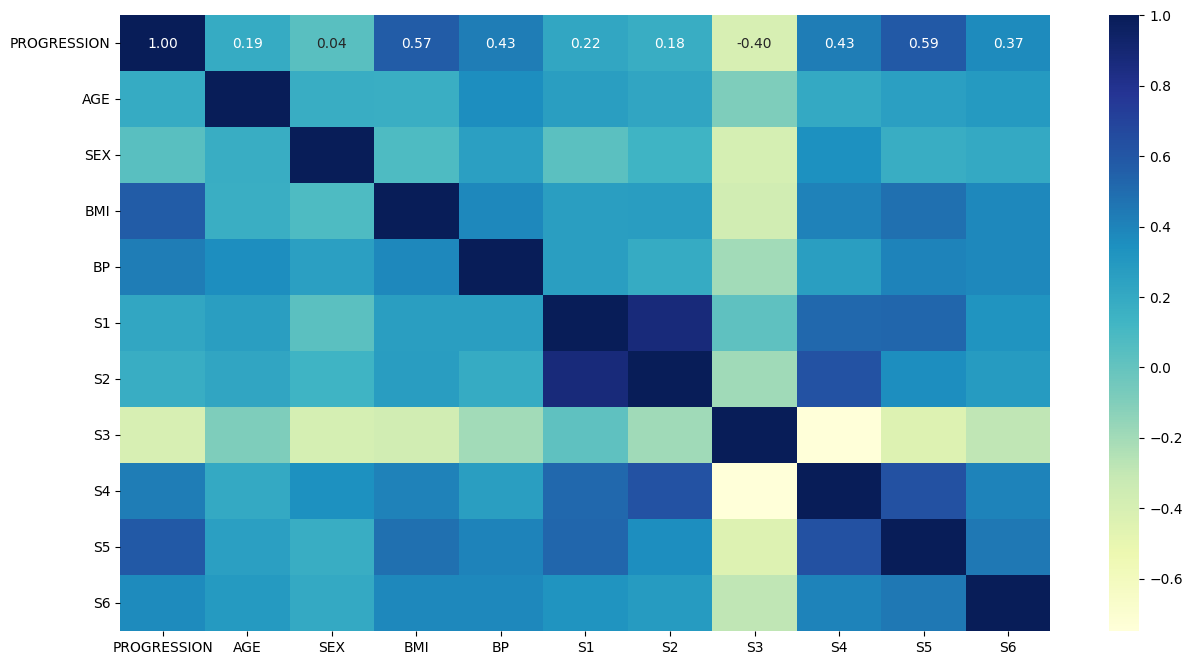

In [159]:
plt.figure(figsize=(15, 8))  # adjust width and height as needed
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="YlGnBu")
plt.show()

- Of all the features, "S5," "BMI," "BP" and "S4" demonstrate the strongest correlations with "PROGRESSION."
- There seems to be strong correlations between S1 & S2 and S3 & S4. It might be worth combining these features. 

In [43]:
# diabetes_df['S1_S2'] = diabetes_df['S1'] * diabetes_df['S2']
# diabetes_df['S3_S4'] = diabetes_df['S3'] * diabetes_df['S4']
# diabetes_df.drop(columns='S1', axis=1, inplace=True)
# diabetes_df.drop(columns='S2', axis=1, inplace=True)
# diabetes_df.head()

## Split dataset into train & test sets

In [137]:
# Define independent features (X) and dependent feature (y)
X = diabetes_df.drop(columns=['PROGRESSION'])  # Independent features
y = diabetes_df['PROGRESSION']  # Dependent feature

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [138]:
features_to_standardise = ['S1', 'S2']
features_to_normalise = ['AGE','SEX','BMI','BP','S3','S4','S5','S6']

In [139]:
# Apply appropriate scaling to the features
# For Gaussian features, use StandardScaler

standard_scaler = StandardScaler()
X_train_standard_scaled = standard_scaler.fit_transform(X_train[features_to_standardise])
X_test_standard_scaled = standard_scaler.transform(X_test[features_to_standardise])


# For non-Gaussian features, use MinMaxScaler
minmax_scaler = MinMaxScaler()
X_train_minmax_scaled = minmax_scaler.fit_transform(X_train[features_to_normalise])
X_test_minmax_scaled_scaled = minmax_scaler.transform(X_test[features_to_normalise])

# Combine the scaled features back together
X_train_scaled = np.hstack((X_train_standard_scaled, X_train_minmax_scaled))
X_test_scaled = np.hstack((X_test_standard_scaled, X_test_minmax_scaled_scaled))

# convert the scaled data back to a DataFrame
X_train = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns)

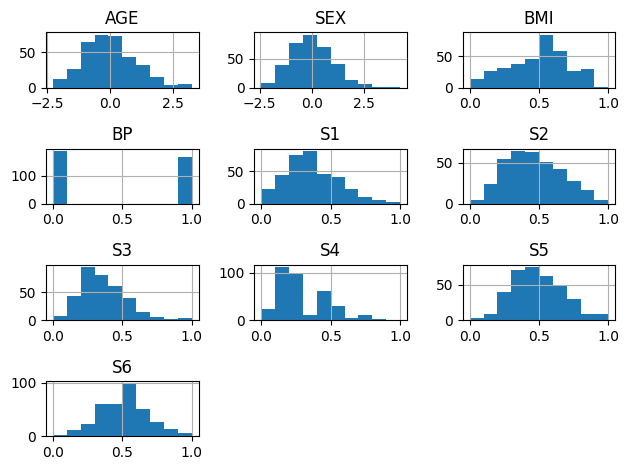

In [140]:
# plot the distributions of the X features after scaling
X_train.hist()
plt.tight_layout()

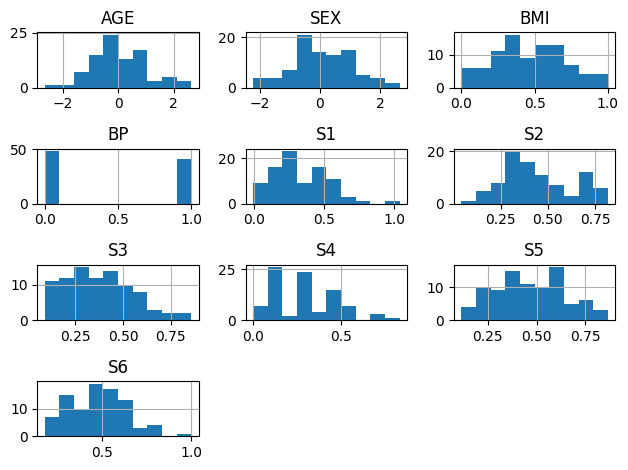

In [141]:
X_test.hist()
plt.tight_layout()

In [142]:
# winsorize the train and test sets separately to deal with the outliers
for column in X_train:
    X_train[column] = mstats.winsorize(X_train[column], limits=(0.10, 0.10))

for column in X_test:
    X_test[column] = mstats.winsorize(X_test[column], limits=(0.10, 0.10))

<Axes: >

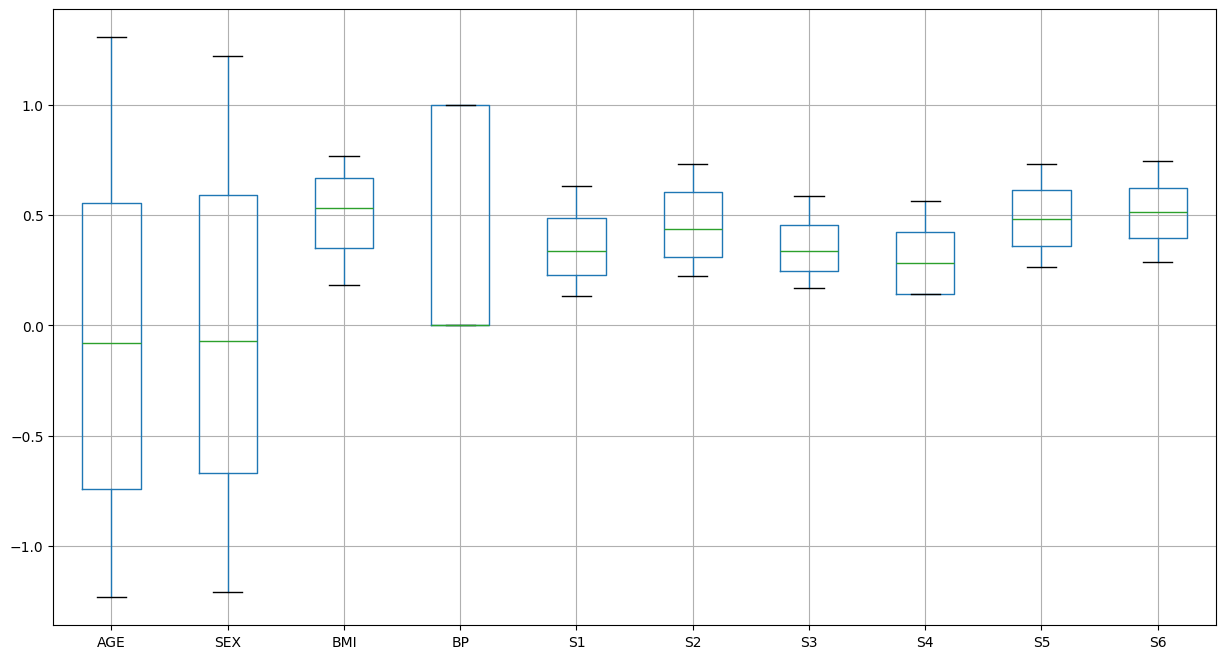

In [143]:
# plot the distribution of the X features after winsorization
X_train.boxplot(figsize=(15, 8))

<Axes: >

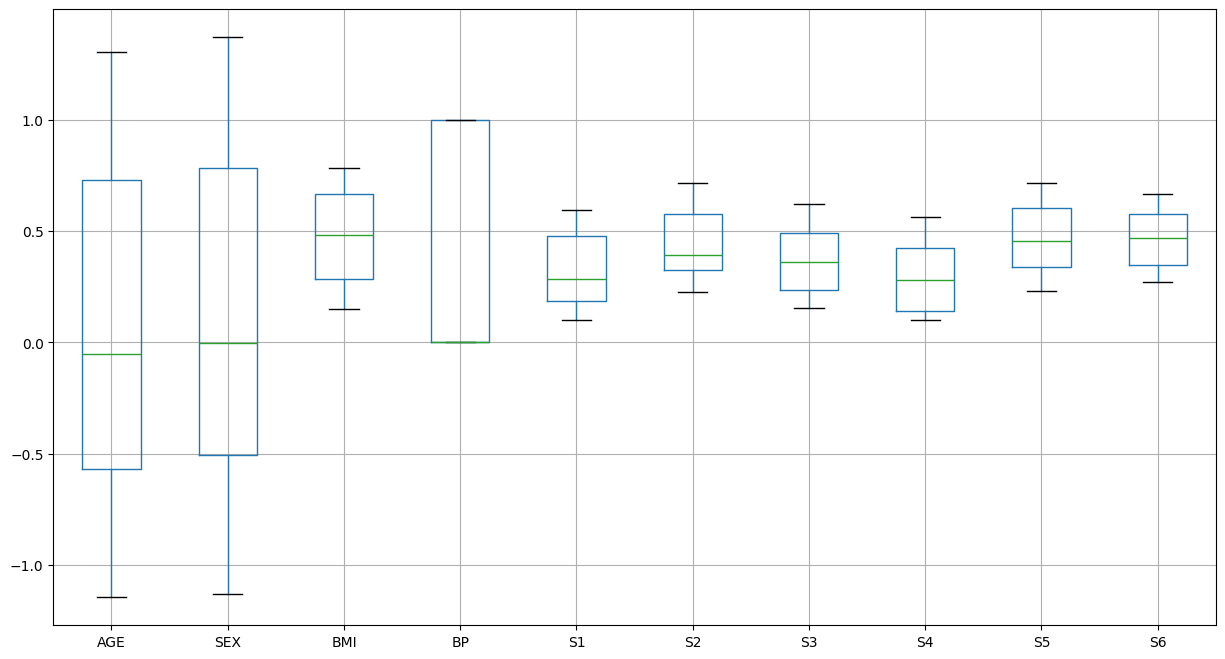

In [144]:
# plot the distribution of the X features after winsorization
X_test.boxplot(figsize=(15, 8))

## Build and fit a multivariate linear regression model

In [145]:
# initiate an empty model
multivariate_reg_model = LinearRegression()

# define a parameter grid for model optimisation
param_grid = {
			'fit_intercept': [True, False],
			'positive': [True, False]
			}
# instantiate GridSearchCV
grid_search = GridSearchCV(multivariate_reg_model, param_grid, cv=5)

# fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# get the best model from the grid search
best_model = grid_search.best_estimator_

# fit the best model to the training data
best_model.fit(X_train, y_train)

# make predictions on the test set
y_pred = best_model.predict(X_test)

In [146]:
# intercept & coefficients of the trained insurance model 
print('Intercept: \n', best_model.intercept_)
print('Coefficients: \n', best_model.coef_)
print('Score: \n', best_model.score(X_test, y_test))

Intercept: 
 0.0
Coefficients: 
 [-15.47986507   3.04823732   9.24010984 -25.18883024 141.50120366
  98.57410289 -88.53284648  12.69745661 172.22306475  15.9156038 ]
Score: 
 0.46565268447670805


##### **Intercept:**

The intercept (β0) represents the value of the dependent variable when all independent variables are zero. In this case, the intercept is zero and it suggests that when all other independent variables are zero, the predicted value of the diabetes progression is also zero.

**Coefficients:**

The coefficients (β1,β2,...,βn) represent the change in the dependent variable for a one-unit change in the corresponding independent variable, holding all other variables constant.
For example, a coefficient of -15.479 for the first independent variable "AGE" suggests that for every one-unit increase in "AGE", the predicted value of the diabetes progression decreases by approximately -15.479, holding all other variables constant.
Similarly, a coefficient of 3.048 for the second independent variable suggests that for every one-unit increase in the second independent variable "SEX", the predicted value of the diabetes progression increases by approximately 3.048, holding all other variables constant.

**Score (R-squared):**

The score, or coefficient of determination R-squared, measures the proportion of the variance in the diabetes progression that is predictable from the independent variables.
A score of 0.4656 means that approximately 46.56% of the variance in the diabetes progression can be explained by the independent variables included in the model.

In other words, the model accounts for about 46.56% of the variability observed in the diabetes progression. This value indicates the proportion of the total variation in the diabetes progression that is explained by the variation in the independent variables.

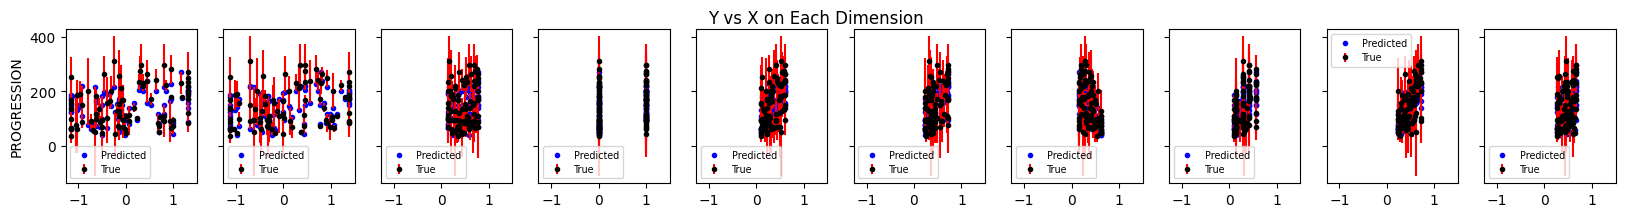

In [156]:
## Plot the errors
fig, ax = plt.subplots(1, X_test.shape[1], sharey=True, sharex=True, figsize=(20,2))
fig.suptitle("Y vs X on Each Dimension")
ax[0].set_ylabel(diabetes_df.columns[0])

# Get values for the error bar
residuals = np.array(y_test - y_pred)
error_bar_values = np.abs(residuals)

# # Plot data, predicted values, and error bars
for i in range(X_test.shape[1]):
    ax[i].errorbar(np.array(X_test)[:, i], np.array(y_test), yerr=error_bar_values, fmt='.k', ecolor='red', label='True')
    ax[i].scatter(np.array(X_test)[:,i], np.array(y_pred), c='b', marker='.', label='Predicted')
    ax[i].legend(loc='best', fontsize='x-small')

In [157]:
# evaluate the performance of the model
mse = mean_squared_error(y_test, y_pred)
r2_square = r2_score(y_test, y_pred)

# print the evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2_square}")

Mean Squared Error: 2831.053164054881
R-squared: 0.46565268447670805


**Mean Squared Error (MSE):** The mean squared error measures the average of the squares of the errors between the actual values (y_test) and the predicted values (y_pred). In this case, the MSE of approximately 2815 means that, on average, the squared difference between the actual diabetes progression and the predicted diabetes progression is around 2831. Since the MSE is a squared metric, its value is sensitive to large errors, and a high MSE indicates poorer model performance.

In [158]:
# save the model
dump(best_model, 'diabetes_reg_model.joblib')

['diabetes_reg_model.joblib']